#### Initialization

In [37]:
from openai import OpenAI
from functools import reduce
import pandas as pd,numpy as np,json,re,os,httpx,pylab as pl
from json_repair import repair_json
from tqdm.notebook import tqdm

local_client=OpenAI(base_url='http://localhost:11434/v1/',api_key='12345')
groq_client=OpenAI(base_url='https://api.groq.com/openai/v1/',api_key=os.environ['GROQKEY'])
pplx_client=OpenAI(base_url='https://api.perplexity.ai',api_key=os.environ['PPLXKEY'])
gpt4o_client=OpenAI(base_url=os.environ['GPTPROXYURL'],api_key=os.environ['GPTPROXYKEY'],
                   http_client=httpx.Client(verify='/Users/wwoon/projects/hackathon/text-search-hackathon-2024/certificates/GAP-proxy-certificate.crt'))

def topic_extraction_msgs(passage):

    return [{'role':'system',
          'content':'You are a helpful research assistant'},
            {'role':'user',
             'content':f"""
             
The following is some content provided by the user:
{passage}

Your main task is to read this abstract carefully and determine the main research domain(s) from the following list. Consider the core concepts, specific algorithms, and techniques discussed in the abstract, not just general machine learning terms:

[List of domains with brief descriptions]
- Kernel Methods: Algorithms using kernel functions for pattern analysis
- Neural Networks: Computational models inspired by biological neural networks
- Deep Learning Architectures: Advanced neural network structures with multiple layers
- Probabilistic Graphical Models: Representations of probabilistic relationships among variables
- Decision Trees and Random Forests: Tree-based models for classification and regression
- Support Vector Machines: Supervised learning models for classification and regression
- Clustering Algorithms: Unsupervised learning techniques for grouping similar data points
- Evolutionary Algorithms: Optimization techniques inspired by biological evolution
- Bayesian Methods: Probabilistic approaches which model solutions as drawn from some distribution
- Ensemble Methods: Techniques combining multiple learning algorithms
- Dimensionality Reduction Techniques: Methods for reducing the number of random variables
- Hidden Markov Models: Statistical models where the system is a Markov process with hidden states
- Convolutional Neural Networks: Deep learning models particularly effective for image processing
- Recurrent Neural Networks: Neural networks designed to work with sequence data
- Generative Adversarial Networks: Deep learning models for generating new data
- Attention Mechanisms: Techniques allowing models to focus on specific parts of input data
- Transfer Learning Methods: Approaches for applying knowledge from one task to another
- Fuzzy Logic Systems: Reasoning based on "degrees of truth" rather than boolean logic
- Natural Language Processing Models: Techniques for processing and analyzing human language
- Reinforcement Learning: Techniques for learning using indirect "rewards" rather than explicit errors

"""+"""
Additional instructions:
1. Provide the response in the form of a JSON object with the following structure:
   {
     "justification": "Brief explanation of why these topics were chosen",
     "main_topic": {"name": "topic_1", "confidence": 0.0-1.0},
     "secondary_topics": [{"name": "topic_2", "confidence": 0.0-1.0}, {"name": "topic_3", "confidence": 0.0-1.0}]
   }
2. Use ONLY topics provided in the list above. If none fit, use "N/A"
3. Include up to two secondary topics if relevant, with a minimum confidence of 0.3.
4. Consider the overall context of the abstract, focusing on specific algorithms, methods, and problem domains discussed.
5. Be aware that general machine learning terms like "training", "convergence", and "performance" are used across many domains. Focus on the unique aspects of each domain.
6. Provide ONLY the JSON response, with no additional comments or text.
"""
          }]

def extract_topics(passage,
                  the_model='mistral-nemo:12b',
                  client=local_client,
                  retries=3):

  for count in range(retries):

    try:
      resp=client.chat.completions.create(
        model=the_model,
        messages=topic_extraction_msgs(passage)
      )
      
      js=json.loads(repair_json(resp.choices[0].message.content))
      return { 
        'main_topic' : js.get("main_topic","N/A"),
        'secondary_topic' : js.get("secondary_topic","N/A"),
        'model' : the_model,
        'num_retries' : count
      }
    except:
      pass

    # Give up
    return { 'main_topic':'N/A' , 'secondary_topic':'N/A' , 'model':the_model, 'num_retries':-1}
          



In [2]:
# Quick functions

def get_topics_groq(inseries):
  extract_topics_groq=lambda x:extract_topics(x,client=groq_client,the_model='llama3-70b-8192')
  res=[]
  for abs in tqdm(inseries):
    res.append(extract_topics_groq(abs)['main_topic']['name'])
  return res

def get_topics_pplx(inseries,the_client=pplx_client,the_model='llama-3.1-sonar-large-128k-chat'):
  extract_topics_pplx=lambda x:extract_topics(x,client=the_client,the_model=the_model)
  res=[]
  for abs in tqdm(inseries):
    try:
      res.append(extract_topics_pplx(abs)['main_topic']['name'])
    except:
      res.append('N/A')
  return res


#### Analysis

In [3]:
## # Loading in the data

# Query openalex from the website, set source is Proceedings of the AAAI Conference on Artificial Intelligence, then year is <year>
nrows=200
the_mod='llama_small'

the_model={"llama_small":"llama-3.1-8b-instruct",
           "llama_large":"llama-3.1-70b-instruct",
           "sonar_small":"llama-3.1-sonar-small-128k-chat",
           "sonar_large":"llama-3.1-sonar-large-128k-chat"}[the_mod]
tpx_={'gpt':lambda x:get_topics_pplx(x,the_client=gpt4o_client,the_model='gpt-4o'),
      'pplx':lambda x:get_topics_pplx(x,the_model=the_model),
      'groq':lambda x:get_topics_groq(x)}['pplx']

pf2023=pd.read_csv("./aaai_data/works-2024-09-06T22-53-09_aaai_2023.csv").head(nrows).assign(topics=lambda x:tpx_(x.abstract))
pf2020=pd.read_csv("./aaai_data/works-2024-09-06T21-59-15_aaai_2020.csv").head(nrows).assign(topics=lambda x:tpx_(x.abstract))
pf2015=pd.read_csv("./aaai_data/works-2024-09-22T22-51-24_aaai_2015.csv").head(nrows).assign(topics=lambda x:tpx_(x.abstract))
pf2010=pd.read_csv("./aaai_data/works-2024-09-06T22-01-39_aaai_2010.csv").head(nrows).assign(topics=lambda x:tpx_(x.abstract))

pf2010.to_csv(f"cached/pf2010_{nrows}topics_{the_mod}.csv")
pf2015.to_csv(f"cached/pf2015_{nrows}topics_{the_mod}.csv")
pf2020.to_csv(f"cached/pf2020_{nrows}topics_{the_mod}.csv")
pf2023.to_csv(f"cached/pf2023_{nrows}topics_{the_mod}.csv")

pf2010.topics.value_counts(),\
pf2020.topics.value_counts(),\
pf2023.topics.value_counts()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(topics
 Reinforcement Learning                 49
 Probabilistic Graphical Models         34
 Evolutionary Algorithms                25
 Natural Language Processing Models     22
 Dimensionality Reduction Techniques    11
 Bayesian Methods                       11
 Fuzzy Logic Systems                     9
 N/A                                     8
 Ensemble Methods                        7
 Decision Trees and Random Forests       7
 Clustering Algorithms                   7
 Support Vector Machines                 4
 Transfer Learning Methods               2
 Convolutional Neural Networks           2
 Constraint Programming                  1
 Kernel Methods                          1
 Name: count, dtype: int64,
 topics
 Natural Language Processing Models     51
 Deep Learning Architectures            50
 Convolutional Neural Networks          40
 Neural Networks                        23
 Reinforcement Learning                 11
 Probabilistic Graphical Models          9
 Recurrent

In [4]:
pf2015=pd.read_csv("./aaai_data/works-2024-09-22T22-51-24_aaai_2015.csv").head(nrows).assign(topics=lambda x:tpx_(x.abstract))
pf2015.to_csv(f"cached/pf2015_{nrows}topics_{the_mod}.csv")

  0%|          | 0/200 [00:00<?, ?it/s]

In [66]:
load_cached=True
if load_cached:
  pf2010=pd.read_csv(f"cached/pf2010_{nrows}topics_{the_mod}.csv")
  pf2015=pd.read_csv(f"cached/pf2015_{nrows}topics_{the_mod}.csv")
  pf2020=pd.read_csv(f"cached/pf2020_{nrows}topics_{the_mod}.csv")
  pf2023=pd.read_csv(f"cached/pf2023_{nrows}topics_{the_mod}.csv")

result_dfs=[pf2010,pf2015,pf2020,pf2023]

basedict={tmp:0 for tmp in 
 reduce(lambda x,y:x.union(y),[set(tmp.topics) for tmp in result_dfs])
 if type(tmp)!=type(1.)}

combined=pd.DataFrame([{**basedict,**tmp.groupby("topics").topics.count().to_dict()} for tmp in result_dfs])

# Figure out reasonable ordering of topics
tmp=combined.tail(1).T
tmp.columns=['n']
tops=tmp.sort_values('n',ascending=False).index
combined=combined[tops]

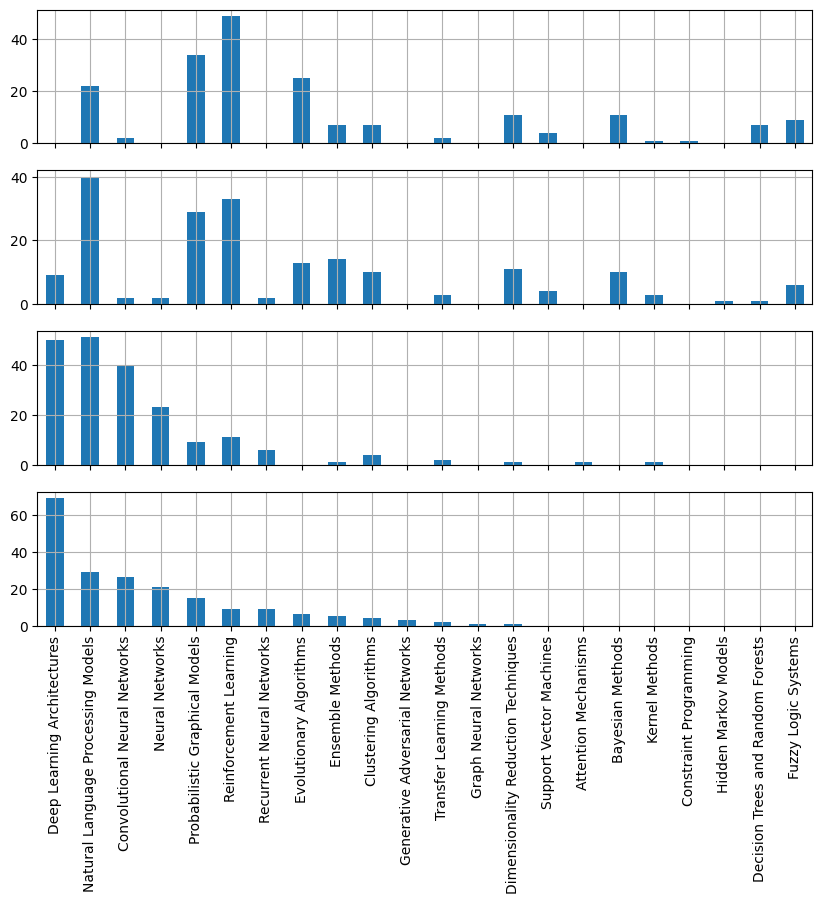

In [69]:
pl.figure(figsize=(10,8))
i=1

for _,row in combined.iterrows():
  pl.subplot(4,1,i)
  row.plot(kind='bar')
  pl.grid(True)

  if i<combined.shape[0]:
    pl.gca().set_xticklabels([])
  i+=1

pl.savefig("200topics.png")

<Axes: xlabel='topics'>

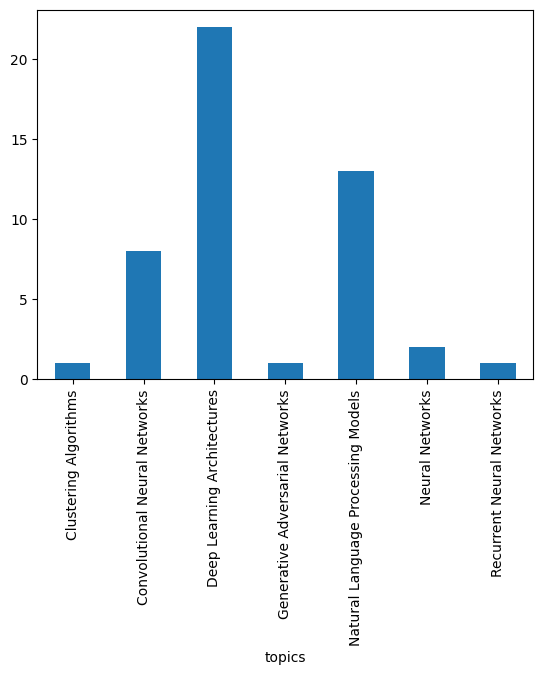

In [76]:
pf2020.groupby("topics").topics.count()

## Scratch

In [35]:
### Older embedding messages:

def topic_extraction_msgs_older(passage):
  
  return [{'role':'system',
          'content':
          """
### You are a helpful assistant. Here are the instructions:

1. The user will provide a passage of text after these instructions.
2. Read the text and determine the main research domain or domains
Please limit the response to  domains selected from the following list:
    * Deep Learning
    * Neural Networks
    * Probabilistic methods
    * Agents
    * Decision Trees
    * Clustering
    * Visualization
    * Kernel methods

3. Provide the response in the form of a json object { "main_topic": topic_1, "secondary_topic": topic_2  }.
4. Again, remember to use ONLY topics provided in the list above. If NONE of them fit, you can fill in "N/A"
5. If there is only one matching topic, or if there is really only one main topic, set the "secondary_topic" to "N/A",   
6. ONLY provide the json response, with no additional comments or text. 

          """
          },
         {'role':'user',
          'content':f"""
### Here is the passage:

{passage}
          """
          }]

def topic_extraction_msgs_old(passage):

    return [{'role':'system',
          'content':
          """
### You are a helpful assistant. Here are the instructions:

1. The user will provide a passage of text after these instructions.
2. Read the text and determine the main research domain(s) from the following list:
    * Deep Learning
    * Neural Networks
    * Probabilistic methods
    * Agents
    * Decision Trees
    * Clustering
    * Visualization
    * Kernel methods

3. Provide the response in the form of a JSON object with the following structure:
   {
     "justification": "Brief explanation of why these topics were chosen",
     "main_topic": {"name": "topic_1", "confidence": 0.0-1.0},
     "secondary_topics": {"name": "topic_2", "confidence": 0.0-1.0}
   }

4. Use ONLY topics provided in the list above. If none fit, use "N/A"
5. Include up to two secondary topics if relevant, with a minimum confidence of 0.3.
6. Consider the overall context of the abstract, not just individual keywords.
7. Provide ONLY the JSON response, with no additional comments or text.
          """
          },
         {'role':'user',
          'content':f"""
### Here is the passage:

{passage}
          """
          }]


In [44]:
extract_topics(pf2020.abstract[0])

{'main_topic': 'N/A',
 'secondary_topic': 'N/A',
 'model': 'mistral-nemo:12b',
 'num_retries': -1}

In [107]:
# Sanity check
testf=pf2010.sample(2)
testf['topics']=testf['abstract'].map(lambda x:extract_topics(x,the_model='gemma2:9b-instruct-q5_1'))

pd.set_option('display.max_colwidth',None)
testf[['abstract','topics']]

,abstract,topics
32,"Auctions are promising decentralized methods for teams of agents to allocate and re-allocate tasks among themselves in dynamic, partially known and time-constrained domains with positive or negative synergies among tasks. Auction-based coordination systems are easy to understand, simple to implement and broadly applicable. They promise to be efficient both in communication (since agents communicate only essential summary information) and in computation (since agents compute their bids in parallel). Artificial intelligence research has explored auction-based coordination systems since the early work on contract networks, mostly from an experimental perspective. This overview paper describes our recent progress towards creating a framework for the design and analysis of cooperative auctions for agent coordination.","{'main_topic': {'name': 'Deep Learning', 'confidence': 0.8}, 'secondary_topic': 'N/A', 'model': 'gemma2:9b-instruct-q5_1', 'num_retries': 0}"
244,"In various domains, such as computer games, robotics, and transportation networks, shortest paths may need to be found quickly. Search time can be significantly reduced if it is known which parts of the graph include ``swamps''---areas that cannot lie on the only available shortest path, and can thus safely be pruned during search. We introduce an algorithm for detecting hierarchies of swamps, and exploiting them. Experiments support our claims of improved efficiency, showing significant reduction in search time.","{'main_topic': {'name': 'Agents', 'confidence': 0.8}, 'secondary_topic': 'N/A', 'model': 'gemma2:9b-instruct-q5_1', 'num_retries': 0}"


In [17]:
#res=pplx_client.chat.completions.create(model='llama-3.1-sonar-large-128k-chat',
#                                        messages=[{'role':'system','content':'you are a helpful assistant'},
#                                                  {'role':'user','content':'how are you doing'}])


res=pplx_client.chat.completions.create(model='llama-3.1-sonar-large-128k-chat',
                                        messages=topic_extraction_msgs('this is an abstract about neural networks'))

res.choices[0].message.content


'```json\n{\n  "justification": "The passage explicitly mentions \'neural networks\', which is a clear indicator of the main research domain.",\n  "main_topic": {"name": "Neural Networks", "confidence": 1.0},\n  "secondary_topics": {"name": "N/A", "confidence": 0.0}\n}\n```'

In [10]:
extract_topics(pf2020.abstract[1],
  client=pplx_client,the_model='llama-3.1-sonar-large-128k-chat')

{'main_topic': {'name': 'Agents', 'confidence': 0.9},
 'secondary_topic': 'N/A',
 'model': 'llama-3.1-sonar-large-128k-chat',
 'num_retries': 0}

In [11]:
get_topics_pplx(pf2020.abstract[:2])

  0%|          | 0/2 [00:00<?, ?it/s]

[{'main_topic': {'name': 'Agents', 'confidence': 0.9},
  'secondary_topic': 'N/A',
  'model': 'llama-3.1-sonar-large-128k-chat',
  'num_retries': 0},
 {'main_topic': {'name': 'Agents', 'confidence': 0.9},
  'secondary_topic': 'N/A',
  'model': 'llama-3.1-sonar-large-128k-chat',
  'num_retries': 0}]